# Lab05 - Tipos de Redes Neuronales

En la sesión pasada creamos nuestra primera **Red Neuronal Profunda** usando capas densas (*Fully Connected*) ya que se trataba de una regresión lineal sencilla.  

Ahora, vamos a crear una **Red Neuronal Convolucional** en un problema muy común de Inteligencia Artificial: Clasificación de imágenes! 

Trate de instalar estas librerias y de cargarlas en su ambiente de trabajo.  Si se encuentra algun error siempre puede trabajar en el ambiente virtual de Colab.

In [3]:
import keras
import cv2
import requests
import zipfile
import matplotlib.pyplot as plt
import numpy as np

from skimage import io
from PIL import Image
from io import BytesIO
from tensorflow.keras import optimizers
from tensorflow.keras import applications
from keras. preprocessing.image import ImageDataGenerator
%matplotlib inline

## Cargar el set de datos
Dependiendo del problema que queramos solucionar, va a ser necesario recolectar una gran cantidad de imágenes para entrenar el modelo.  Existen fuentes de datos abiertas para casos de uso generales como: personas, animales, flores, automóviles, etc.  
Por otro lado, cuándo nuestro problema es mucho más particular y no se encuentran datasets ya creados para nuestro caso, será necesario recolectar las imágenes manualmente.  La regla siempre será: *Entre más imágenes, mejor*.  
En cualquiera de los dos casos, la estructura recomendable para organizar las imágenes es la siguiente:
```
Directorio Raíz
└───train
│   └───clase1
│   │       imagen01.jpg
│   │       imagen02.jpg
│   │       ...
│   └───clase2
│   │       imagen01.jpg
│   │       imagen02.jpg
│   │       ...
│   └───...
│   
└───test
    └───clase1
    │       imagen01.jpg
    │       imagen02.jpg
    │       ...
    └───clase2
    │       imagen01.jpg
    │       imagen02.jpg
    │       ...
    └───...
```

Los directorios no *necesariemante* deben llamarse así, pero sí es recomendable tener un set de datos de entrenamiento separado del de pruebas.  Además, los **nombres** de las carpetas dentro de estos (clase1, clase2, ...), son los que indicarán las **clases/labels** de las imagenes que están adentro.

Vamos a trabajar con un dataset de Logos de algunas empresas conocidas, que para facilidad ya se encuentra descargado y  organizado en la estructura necesaria dentro de nuestra carpeta */data*:
![Logos_sample](http://flovv.github.io/figures/post21/flickr27-sample.png)

In [4]:
# Descargar Imagenes
url = "https://github.com/monitarb/diplomado_DS/blob/main/LogoData.zip?raw=true"
filename = 'LogoData.zip'
with open(filename, "wb") as f:
    r = requests.get(url)
    f.write(r.content)

# Descomprimir archivo
with zipfile.ZipFile(filename, 'r') as zip_ref:
    zip_ref.extractall('data')

El dataset consta de 675 imágenes de 27 marcas diferentes (En promedio 25 imágenes de cada clase para entrenamiento y pruebas).  En un problema real esto es un dataset pequeño, pero hoy nos servirá para aprender otros conceptos de Redes Neuronales.

## 5a. Mi Primera Red Neuronal Convolucional CNN

In [5]:
# Configuración de variables
img_width = 32
img_height = 32
train_samples = 498
validation_samples = 177
classes = ['Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari', 'Ford', 'Google', 
           'Heineken', 'HP', 'Intel', 'McDonalds', 'Mini', 'Nbc', 'Nike', 'Pepsi', 'Porsche', 'Puma', 
           'RedBull', 'Sprite', 'Starbucks', 'Texaco', 'Unicef', 'Vodafone', 'Yahoo']

train_directory = "data/train"
test_directory = "data/test"

In [6]:
# Configuración de Hiperparámetros:
batch_size = 8
learning_rate = 0.0001
epochs = 50

### Data Augmentation
Como ya se ha mencionado varias veces, entre más datos tengamos, mejor.  En el caso de Computer Vision: entre más imágenes, mejor.
Cuando no tenemos suficientes datos, la técnica de Data Augmentation permite, por medio de un algoritmo, generar imágenes artificialmente a partir de las pocas imágenes que tenemos.  Esto se logra haciendo cambios pequeños a los datos: Girar un poco la imagen, cambiando su luminocidad, resolución, moviéndola un poco, etc.  Para nosotros es un cambio pequeño, pero para el modelo es una imagen completamente diferente!
![Data Augmenation](https://miro.medium.com/max/605/0*Utma-dS47hSoQ6Zt)  
A nivel de código, estas son TODAS las opciones que se pueden configurar para el generador de datos, tenga en cuenta que no siempre todas aplican, por ejemplo, la imagen del león mirando a la derecha o mirando a la izquierda, sigue siendo un león, pero, nuestros logos?

In [7]:
# Estas son TODAS las opciones!
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    zca_epsilon=1e-06,
    rotation_range=0,
    width_shift_range=0.0,
    height_shift_range=0.0,
    brightness_range=None,
    shear_range=0.0,
    zoom_range=0.0,
    channel_shift_range=0.0,
    fill_mode="nearest",
    cval=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=None
)

In [8]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

In [9]:
train_generator = datagen.flow_from_directory(
    directory=train_directory,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    seed = 123
)

validation_generator = datagen.flow_from_directory(
    directory=test_directory,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle = True,
    seed = 123
)

Found 498 images belonging to 27 classes.
Found 177 images belonging to 27 classes.


Hemos creado dos generadores de imagenes porque cada dataset partirá de un directorio diferente, y puede ser con transformaciones diferentes.  
Ahora sí, podemos crear el modelo:

In [10]:
model = keras.Sequential()

model.add(keras.layers.convolutional.Conv2D(filters=16, kernel_size = (3,3), 
                                            input_shape=(img_width, img_height,3)))
model.add(keras.layers.Activation(activation='relu'))
model.add(keras.layers.convolutional.MaxPooling2D(pool_size = (2,2)))

model.add(keras.layers.convolutional.Conv2D(filters=32, kernel_size = (3,3)))
model.add(keras.layers.Activation(activation='relu'))
model.add(keras.layers.convolutional.MaxPooling2D(pool_size = (2,2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64))
model.add(keras.layers.Activation(activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(27)) ## Salida: 27 clases
model.add(keras.layers.Activation(activation='softmax'))

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 activation (Activation)     (None, 30, 30, 16)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 13, 13, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                    

En el resumen que nos entrega el modelo podemos ver:
- Estructura de la red, capa por capa
- Como van disminuyendo las dimensiones de cada capa, empezando por las dimensiones de la imágen (30,30) hasta la última capa = Número de clases (27)
- Cantidad de parámetros que se van a calcular/entrenar: 80.635

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['accuracy'])

In [13]:
history = model.fit(train_generator, 
                    steps_per_epoch = int(train_samples/batch_size), 
                    epochs = epochs, 
                    validation_data = validation_generator,
                    validation_steps = int(validation_samples/batch_size))

Epoch 1/50
62/62 [==============================] - 11s 45ms/step - loss: 3.3203 - accuracy: 0.0327 - val_loss: 3.3027 - val_accuracy: 0.0398
Epoch 2/50
62/62 [==============================] - 3s 40ms/step - loss: 3.2945 - accuracy: 0.0449 - val_loss: 3.2909 - val_accuracy: 0.0568
Epoch 3/50
62/62 [==============================] - 1s 22ms/step - loss: 3.2825 - accuracy: 0.0469 - val_loss: 3.2901 - val_accuracy: 0.0511
Epoch 4/50
62/62 [==============================] - 2s 28ms/step - loss: 3.2808 - accuracy: 0.0347 - val_loss: 3.2773 - val_accuracy: 0.0284
Epoch 5/50
62/62 [==============================] - 1s 23ms/step - loss: 3.2688 - accuracy: 0.0449 - val_loss: 3.2732 - val_accuracy: 0.0625
Epoch 6/50
62/62 [==============================] - 2s 28ms/step - loss: 3.2611 - accuracy: 0.0531 - val_loss: 3.2589 - val_accuracy: 0.0795
Epoch 7/50
62/62 [==============================] - 2s 31ms/step - loss: 3.2534 - accuracy: 0.0653 - val_loss: 3.2482 - val_accuracy: 0.0909
Epoch 8/50
6

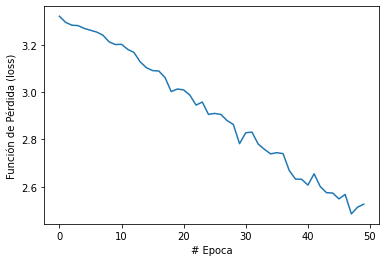

In [14]:
plt.xlabel('# Epoca')
plt.ylabel("Función de Pérdida (loss)")
plt.plot(history.history['loss'])

En la gráfica de **loss** podemos ver cómo va disminuyendo nuestro *categorical_crossentropy* en cada epoca.  
También podemos ver los valores finales del loss y el accuracy:

In [15]:
model.evaluate_generator(validation_generator, validation_samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[2.613356828689575, 0.28248587250709534]

Una vez aprobemos nuestro modelo, podemos usarlo para predecir sobre imágenes nuevas:

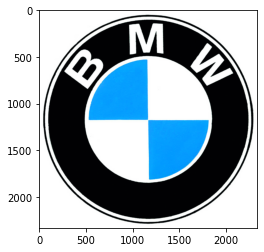

In [16]:
img_path  = "https://i.pinimg.com/originals/07/0d/3e/070d3e118fa9bcf14bf6a1004308c91b.jpg"
response = requests.get(img_path)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [17]:
img = io.imread(img_path)
img = cv2.resize(img, (img_width, img_height)).astype(np.float32)
img = np.expand_dims(img, axis=0)
prediction = model.predict(img)
prediction

1/1 [==============================] - 0s 99ms/step


array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

El resultado de la predicción es la salida de la última neurona, es decir 27 valores que siginifican la probabilidad de que la imagen dada pertenesca a cada una de las 27 clases objetivo.  

In [18]:
len(prediction[0])

27

Para saber, entonces, la clase que indica la predicción basta con elegir la probabilidad más alta del vector entregado, pues corresponden, por índice a las clases objetivo:

In [19]:
classes[prediction.argmax()]

'BMW'

**Taller:**  
A pesar de que para este ejemplo, el modelo hizo una predicción correcta, el loss aún está un poco alto, y el accuracy esta muy bajo.  Además, el valor de *accuracy* para el set de entrenamiento fue más alto que el de pruebas, quiere decir que el modelo está aprendiendo de memoria casos particulres, en lugar de patrones generales (Sobreajuste).  Para ello:
- Juegue un poco con los hiperparámetros, capas y funciones de activación para mejorar estos valores.  Para ello peude usar la documentación de [keras](https://keras.io/api/)
- Busque otra imagen (*.jpg*) de alguno de los logos en nuestro modelo y haga la predicción.  Funciona? Estamos safisfechos con este modelo? Podria mejorar?


## 5b. Transfer Learning  
Para no tener que diseñar la red desde ceros, pensando qué capas, neuronas y funciones de activación usar, usamos Transfer Learning, en el que tomamos la estructura de una red ya contruida y especializada en una tarea específica (Ej: Reconocimiento de imagen).  
Los siguientes pasos iniciales siguen siendo necesarios: 
- Definición de hiperparámetros
- Generador de imagenes nuevas (Data Augmentation)
- Configuración de generadores para entrenamiento y pruebas  

Pero en lugar de crear un modelo desde ceros, vamos a tomar un modelo ya existente, por ejemplo VGG16 y vamos a indicar que sus capas NO SON reentrenables:

In [20]:
base_model = applications.VGG16(weights='imagenet', include_top=False)

for layer in base_model.layers :
    layer.trainable = False

base_model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

Vemos la estructura tan compleja que tiene esta red ya preentrenada, más de 14.5 millones de parámetros!  En este caso, también hemos indicado que este modelo no sea reentrenable.  
También hemos indicado al modelo no incluir la "cabeza" de la red, pues las últimas capas las vamos a reescribir nosotros mismos:
> Ya hemos visto una forma de definir la red: definifiendo el modelo Sequencial vacío e ir añadiendo capas (*model.add*).  
> Otra forma es definiendo cada capa, y agregándola como entrada de la capa siguiente:

In [43]:
capa_inicial = keras.Input(shape=(img_width, img_height, 3), name = 'image_input')

model_head = base_model(capa_inicial)

model_head = keras.layers.GlobalAveragePooling2D()(model_head)
model_head = keras.layers.Dropout(0.4)(model_head)
model_head = keras.layers.Dense(27)(model_head)
model_head = keras.layers.Activation(activation='softmax')(model_head)

my_model = keras.Model(capa_inicial, model_head)

In [44]:
my_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image_input (InputLayer)    [(None, 32, 32, 3)]       0         
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 27)                13851     
                                                                 
 activation_9 (Activation)   (None, 27)                0         
                                                           

Vemos ahora que, la estructura de nuestra nueva red es mucho más compleja, incluye los 14.5 millones de parámetros del modelo VGG16, adicionalmente hemos configurado la capa de entrada para que reciba las imágenes que tenemos preparadas, pero lo más importante, hemos configurado algunas capas adicionales como la **nueva cabeza** de la red.  
Al final del resumen vemos que, los 14.5 millones de parámetros del modelo base (VGG16) no son entrenables, pero los 34mil de nuestra nueva cabeza sí, y estos son los valores que va a buscar el modelo.  

Hemos creado en pocas líneas un modelo más complejo, pero más sencillo de entrenar.  Desde aquí la compilación y entrenamiento del modelo es igual a como ya lo hemos trabajado:

In [45]:
my_model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=learning_rate),
              metrics=['accuracy'])

Como paso adicional de este laboratorio vamos a trabajar con los Callbacks que vimos la sesión pasada.  Son funciones que se ejecutan al final de cada época y que pueden ayudar a mejorar el rendimiento del modelo:

In [46]:
mis_callbacks = [
    # Modificar el LR si el modelo no mejora:
    keras.callbacks.ReduceLROnPlateau(monitor = "val_loss", factor=.1, patience=5),
    # Configurar que el modelo pare si no mejora:
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='auto'),
    # Ir guardando el mejor modelo
    keras.callbacks.ModelCheckpoint("models/logos_checkpoints.h5", monitor='val_loss', save_best_only=True)
]

In [47]:
history = my_model.fit(train_generator, 
                    steps_per_epoch = int(train_samples/batch_size), 
                    epochs = epochs, 
                    validation_data = validation_generator,
                    validation_steps = int(validation_samples/batch_size),
                    callbacks = mis_callbacks)

Epoch 1/50
62/62 [==============================] - 3s 36ms/step - loss: 3.7933 - accuracy: 0.0265 - val_loss: 3.4334 - val_accuracy: 0.0455 - lr: 1.0000e-04
Epoch 2/50
62/62 [==============================] - 2s 28ms/step - loss: 3.7040 - accuracy: 0.0469 - val_loss: 3.3907 - val_accuracy: 0.0455 - lr: 1.0000e-04
Epoch 3/50
62/62 [==============================] - 3s 41ms/step - loss: 3.5606 - accuracy: 0.0367 - val_loss: 3.3291 - val_accuracy: 0.0341 - lr: 1.0000e-04
Epoch 4/50
62/62 [==============================] - 2s 28ms/step - loss: 3.5171 - accuracy: 0.0510 - val_loss: 3.2747 - val_accuracy: 0.0511 - lr: 1.0000e-04
Epoch 5/50
62/62 [==============================] - 2s 28ms/step - loss: 3.4537 - accuracy: 0.0571 - val_loss: 3.2277 - val_accuracy: 0.0568 - lr: 1.0000e-04
Epoch 6/50
62/62 [==============================] - 2s 28ms/step - loss: 3.4148 - accuracy: 0.0592 - val_loss: 3.1920 - val_accuracy: 0.0909 - lr: 1.0000e-04
Epoch 7/50
62/62 [==============================] - 

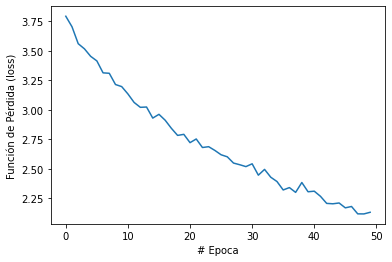

In [48]:
plt.xlabel('# Epoca')
plt.ylabel("Función de Pérdida (loss)")
plt.plot(history.history['loss'])

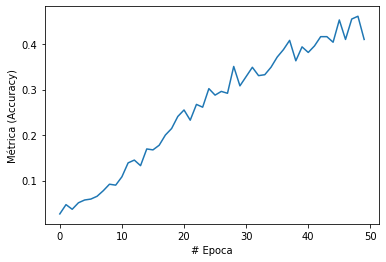

In [49]:
plt.xlabel('# Epoca')
plt.ylabel("Métrica (Accuracy)")
plt.plot(history.history['accuracy'])

In [50]:
my_model.evaluate_generator(validation_generator, validation_samples)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[2.4851438999176025, 0.3502824902534485]

En comparación con nuestro modelo inicial (*Loss = 2.59, Accuracy=0.31*), este modelo da mejores resultados!  
Vamos ahora a probarlo con imágenes nuevas:

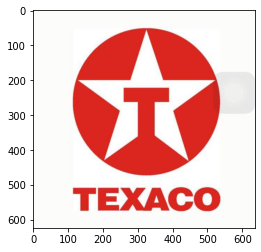

In [51]:
img_path  = "https://i.pinimg.com/originals/02/ac/cd/02accd95989df4cde2f57adcd508dbcd.jpg"
response = requests.get(img_path)
img = Image.open(BytesIO(response.content))
plt.imshow(img)

In [52]:
img = io.imread(img_path)
img = cv2.resize(img, (img_width, img_height)).astype(np.float32)
img = np.expand_dims(img, axis=0)
prediction = my_model.predict(img)
prediction

1/1 [==============================] - 0s 154ms/step


array([[0.0000000e+00, 3.2304660e-37, 0.0000000e+00, 1.2726110e-35,
        1.2160936e-08, 0.0000000e+00, 1.1880011e-36, 0.0000000e+00,
        0.0000000e+00, 2.5823599e-37, 9.6639931e-20, 0.0000000e+00,
        0.0000000e+00, 2.7197143e-21, 0.0000000e+00, 0.0000000e+00,
        2.9951786e-37, 1.7713512e-15, 0.0000000e+00, 3.7459320e-38,
        2.9308796e-36, 0.0000000e+00, 0.0000000e+00, 9.9992716e-01,
        0.0000000e+00, 7.2848365e-05, 0.0000000e+00]], dtype=float32)

In [53]:
len(prediction[0])

27

In [54]:
classes[prediction.argmax()]

'Texaco'

**Taller**  
Note, que de todas formas, al modelo le falta un poco de afinamiento (Accuracy), intente:
- Cambiar el modelo base VGG16 por otros modelos como *VGG19, ResNet50, InceptionV3, MobileNet, Xception*.  Para ello puede usar la documentación de [keras](https://keras.io/api/)
- Juegue un poco con los hiperparámetros, capas y funciones de activación en la **cabeza de la red** para mejorar los valores de loss, accuracy y las predicciones.
- Busque otra imagen (*.jpg*) de alguno de los logos en nuestro modelo y haga la predicción.  Funciona? Estamos safisfechos con este modelo? Podria mejorar?